In [ ]:
!pip install tensorflow keras opencv-python


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
zip_path = '/content/drive/My Drive/Group20_AI_Final/archive.zip'
print(zip_path)


/content/drive/My Drive/Group20_AI_Final/archive.zip


## DATA PREPROCESSING AND FEATURE ENGINEERING

In [ ]:
import zipfile
import os

# Unzipping the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/fer2013')  # You can change the extraction path if needed


In [ ]:
# Define paths to training and testing directories
train_dir = '/content/fer2013/train'
test_dir = '/content/fer2013/test'

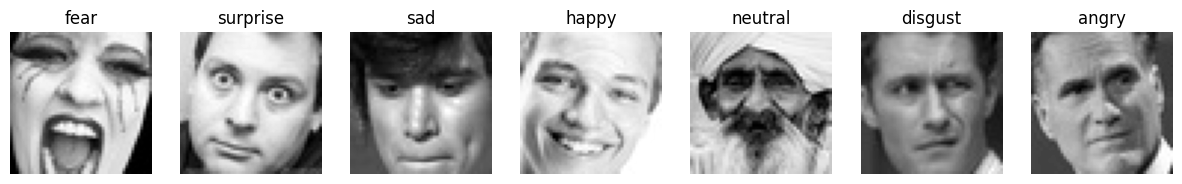

In [ ]:
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image

train_dir = '/content/fer2013/train'

# Display the first image from each category
emotions = os.listdir(train_dir)
plt.figure(figsize=(15, 5))
for i, emotion in enumerate(emotions):
    emotion_folder = os.path.join(train_dir, emotion)
    for file in os.listdir(emotion_folder):
        img_path = os.path.join(emotion_folder, file)
        img = Image.open(img_path)
        plt.subplot(1, len(emotions), i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(emotion)
        plt.axis('off')
        break
plt.show()

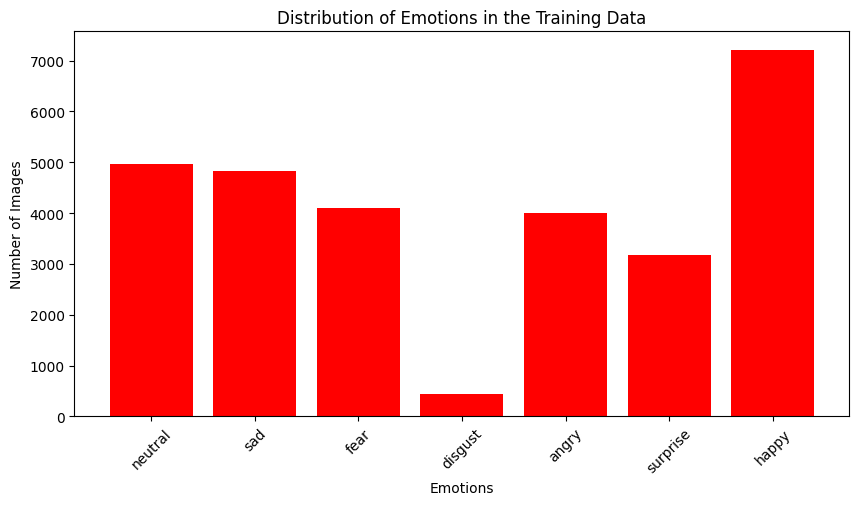

In [ ]:
# Plot a histogram of the distribution of emotions
emotion_counts = [len(os.listdir(os.path.join(train_dir, emotion))) for emotion in emotions]

plt.figure(figsize=(10, 5))
plt.bar(emotions, emotion_counts, color='red')
plt.xlabel('Emotions')
plt.ylabel('Number of Images')
plt.title('Distribution of Emotions in the Training Data')
plt.xticks(rotation=45)
plt.show()

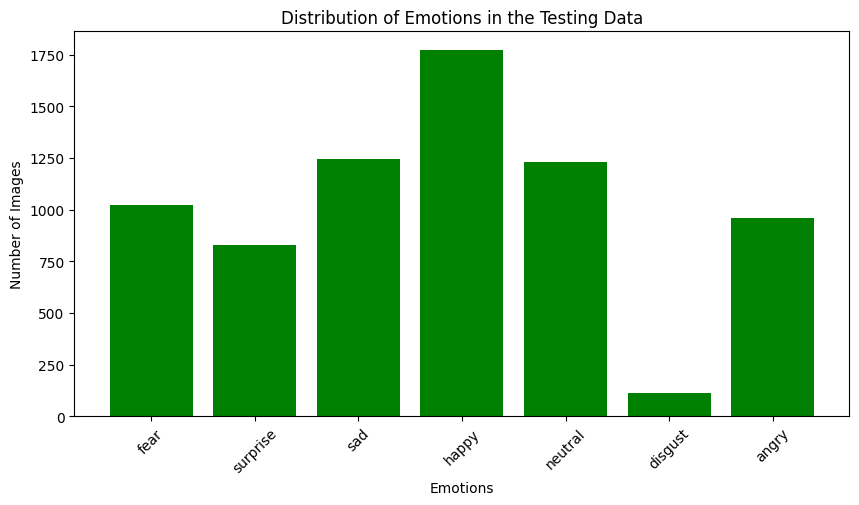

In [ ]:
# Plot a histogram of the distribution of emotions
emotion_counts = [len(os.listdir(os.path.join(test_dir, emotion))) for emotion in emotions]

plt.figure(figsize=(10, 5))
plt.bar(emotions, emotion_counts, color='green')
plt.xlabel('Emotions')
plt.ylabel('Number of Images')
plt.title('Distribution of Emotions in the Testing Data')
plt.xticks(rotation=45)
plt.show()

The histogram displays a varying number of images for each emotion category, indicating an imbalanced dataset. The 'happy' category has the highest number of images, significantly more than other emotions, while 'disgust' has the least. Such imbalance can affect the performance of the model, as they may become biased towards the more represented classes. To mitigate this, class weights can be computed and used during training to give more importance to underrepresented classes

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

# The compute_class_weight function returns an array where each index corresponds
# to the class at the same index in train_generator.class_indices
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

print("Computed class weights:", class_weights_dict)


Computed class weights: {0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


In this project, feature engineering diverges from traditional methods by leveraging an ImageDataGenerator for real-time data augmentation, which enriches the dataset without manual feature creation.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

def convert_to_rgb(image):
    if image.ndim == 2:
        image = np.expand_dims(image, axis=-1)
    return np.repeat(image, 3, axis=-1)

# Update the ImageDataGenerators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=20,
    color_mode='rgb',  # Images are loaded as RGB
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(48, 48),
    batch_size=20,
    color_mode='rgb',  # Same here
    class_mode='categorical'
)

sample_batch, _ = next(train_generator)
print("Batch image shape:", sample_batch[0].shape)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Batch image shape: (48, 48, 3)


## **TRAINING, EVALUATION, OPTIMISATION AND EVALUATION**

Importing pretrained model

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam

vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
vgg16.trainable = False  #freezing all VGG16 layers

model = models.Sequential([
    vgg16,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  # Higher dropout for regularization
    layers.Dense(7, activation='softmax')  # 7 emotion classes
])

model.compile(optimizer=Adam(learning_rate=0.0001),  # Lower learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 14847815 (56.64 MB)
Trainable params: 133127 (520.03 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


This approach leverages transfer learning from VGG16, efficiently using pre-trained weights to reduce training time and computational cost. Fine-tuning the last layers allows for model specificity without exhaustive hyperparameter search. Adaptive callbacks like ReduceLROnPlateau and EarlyStopping optimize learning rates and prevent overfitting dynamically, ensuring the best model version is retained with ModelCheckpoint. This method balances performance with practical constraints, making it suitable for limited resources while still achieving high accuracy

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Unfreeze more layers
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
for layer in vgg16.layers[:-10]:  # Unfreeze the last 10 layers
    layer.trainable = True


model = models.Sequential([
    vgg16,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),  # More neurons in the dense layer
    layers.Dropout(0.5),
    layers.Dense(7, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-7, verbose=1)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=test_generator,
    validation_steps=50,
    callbacks=[early_stopping, model_checkpoint, reduce_lr],
    verbose=1
)

test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test accuracy: {test_accuracy*100:.2f}%")


Epoch 1/30
100/100 [==============================] - ETA: 0s - loss: 1.9090 - accuracy: 0.1945
Epoch 1: val_loss improved from inf to 1.85469, saving model to best_model.h5
100/100 [==============================] - 193s 2s/step - loss: 1.9090 - accuracy: 0.1945 - val_loss: 1.8547 - val_accuracy: 0.2270 - lr: 1.0000e-04


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/30
100/100 [==============================] - ETA: 0s - loss: 1.8288 - accuracy: 0.2350
Epoch 2: val_loss did not improve from 1.85469
100/100 [==============================] - 193s 2s/step - loss: 1.8288 - accuracy: 0.2350 - val_loss: 1.8918 - val_accuracy: 0.1430 - lr: 1.0000e-04
Epoch 3/30
100/100 [==============================] - ETA: 0s - loss: 1.8018 - accuracy: 0.2395
Epoch 3: val_loss improved from 1.85469 to 1.74474, saving model to best_model.h5
100/100 [==============================] - 190s 2s/step - loss: 1.8018 - accuracy: 0.2395 - val_loss: 1.7447 - val_accuracy: 0.2540 - lr: 1.0000e-04
Epoch 4/30
100/100 [==============================] - ETA: 0s - loss: 1.7284 - accuracy: 0.2961
Epoch 4: val_loss improved from 1.74474 to 1.64509, saving model to best_model.h5
100/100 [==============================] - 191s 2s/step - loss: 1.7284 - accuracy: 0.2961 - val_loss: 1.6451 - val_accuracy: 0.3240 - lr: 1.0000e-04
Epoch 5/30
100/100 [==============================] - 

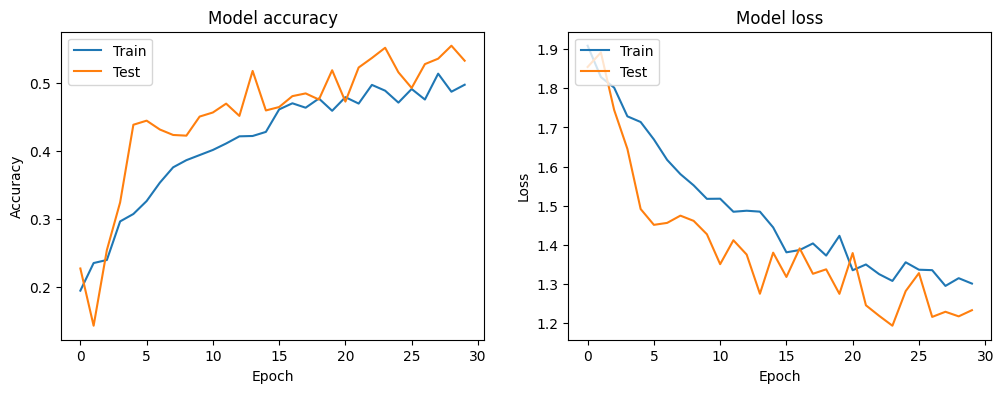

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()


Modifying training parameters to improve accuracy from 53%

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import roc_auc_score
from tensorflow.keras.utils import to_categorical
import numpy as np

# Define VGG16 base model and unfreeze the last convolutional block
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
for layer in vgg16.layers[-6:]:  # Unfreeze the last 6 layers
    layer.trainable = True

# Add custom layers
model = models.Sequential([
    vgg16,
    layers.GlobalAveragePooling2D(),  # Using global average pooling to reduce model complexity
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(7, activation='softmax')  # 7 emotion classes
])

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_dir = '/content/fer2013/train'
test_dir = '/content/fer2013/test'

# Generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical')

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=5, min_lr=1e-7, verbose=1)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
    validation_data=test_generator,
    validation_steps=len(test_generator),
    callbacks=[early_stopping, model_checkpoint, reduce_lr],
    verbose=1
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy*100:.2f}%")

# Predict probabilities for each class
predictions = model.predict(test_generator, steps=len(test_generator))

# Compute true binary labels based on the test generator's classes
true_labels = to_categorical(test_generator.classes, num_classes=7)

# Calculate the ROC AUC score
roc_auc = roc_auc_score(true_labels, predictions)
print(f"Test ROC AUC score: {roc_auc:.2f}")



Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Epoch 1/100
898/898 [==============================] - ETA: 0s - loss: 1.6873 - accuracy: 0.3295
Epoch 1: val_accuracy improved from -inf to 0.44581, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


898/898 [==============================] - 85s 77ms/step - loss: 1.6873 - accuracy: 0.3295 - val_loss: 1.4399 - val_accuracy: 0.4458 - lr: 1.0000e-05
Epoch 2/100
898/898 [==============================] - ETA: 0s - loss: 1.4605 - accuracy: 0.4443
Epoch 2: val_accuracy improved from 0.44581 to 0.51686, saving model to best_model.h5
898/898 [==============================] - 67s 75ms/step - loss: 1.4605 - accuracy: 0.4443 - val_loss: 1.2566 - val_accuracy: 0.5169 - lr: 1.0000e-05
Epoch 3/100
898/898 [==============================] - ETA: 0s - loss: 1.3609 - accuracy: 0.4846
Epoch 3: val_accuracy improved from 0.51686 to 0.53566, saving model to best_model.h5
898/898 [==============================] - 67s 75ms/step - loss: 1.3609 - accuracy: 0.4846 - val_loss: 1.2091 - val_accuracy: 0.5357 - lr: 1.0000e-05
Epoch 4/100
898/898 [==============================] - ETA: 0s - loss: 1.3055 - accuracy: 0.5067
Epoch 4: val_accuracy improved from 0.53566 to 0.55503, saving model to best_model.h5
8

In [ ]:
best_accuracy = max(history.history['accuracy'])
print(f"Best training accuracy: {best_accuracy*100:.2f}%")

Best training accuracy: 78.95%


## **SIMPLE TEST:**

I will pass a angry image to see which emotion will be detected

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import cv2

In [ ]:
model = load_model('/content/drive/My Drive/Group20_AI_Final/best_model.h5') #Loading best model from training

In [ ]:
# passing angry image of  to test model
test_image = load_img('/content/drive/My Drive/Group20_AI_Final/Blessing.jpg', color_mode='grayscale', target_size=(48, 48))
test_image = img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
test_image /= 255.0

In [ ]:
prediction = model.predict(test_image)
emotion_index = np.argmax(prediction)
emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
predicted_emotion = emotions[emotion_index]
print("Predicted Emotion:", predicted_emotion)

1/1 [==============================] - 0s 457ms/step
Predicted Emotion: Angry


Test2: Capturing an image instantly to predict the emotion

<IPython.core.display.Javascript object>

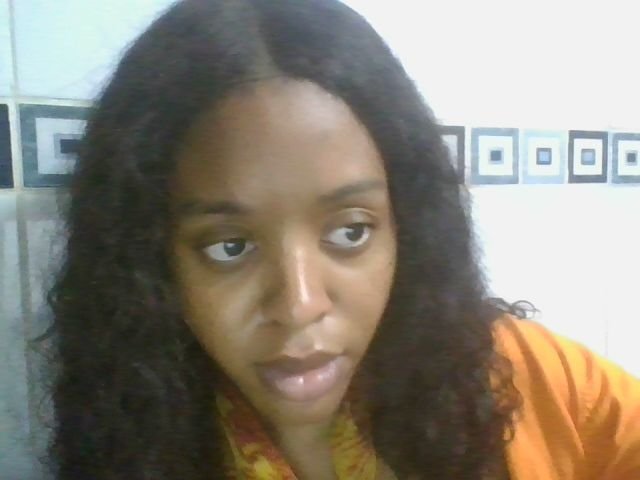

In [ ]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
    js_code = '''
    async function takePhoto(quality) {
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = 'Capture';
        div.appendChild(capture);

        const video = document.createElement('video');
        video.style.display = 'block';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});

        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

        await new Promise((resolve) => capture.onclick = resolve);

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getVideoTracks()[0].stop();
        div.remove();
        return canvas.toDataURL('image/jpeg', quality);
    }
    '''
    display(Javascript(js_code))
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

# Capture the image and display it
image_path = take_photo()
display(Image(image_path))



In [ ]:
# Function to load the image and predict emotion
def predict_emotion(image_path, model):
    # Load and preprocess the captured image
    captured_image = load_img(image_path, color_mode='grayscale', target_size=(48, 48))
    captured_image = img_to_array(captured_image)
    captured_image = np.expand_dims(captured_image, axis=0)
    captured_image /= 255.0  # Normalize the image

    # Predict the emotion
    prediction = model.predict(captured_image)
    emotion_index = np.argmax(prediction)
    emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']  # Update with your classes
    predicted_emotion = emotions[emotion_index]
    print("Predicted Emotion:", predicted_emotion)

# Assuming your model is already loaded
predict_emotion(image_path, model)  # Call the function with the captured image path and model


1/1 [==============================] - 0s 24ms/step
Predicted Emotion: Surprise
